In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
OUTPUT_PATH = "/data/laviniad/sermons-ir/modeling_bible/"
RUN_ID = "042" # not here

output_file = f"{OUTPUT_PATH}output_{RUN_ID}.csv"
output = pd.read_csv(output_file)
args = f"{OUTPUT_PATH}args.json"
args = json.load(open(args))

FileNotFoundError: [Errno 2] No such file or directory: '/data/laviniad/sermons-ir/modeling_bible/output_042.csv'

In [3]:
print("Number of instances in output: " + str(len(output)))
output.head()

Number of instances in output: 61183


,speech_id,token,token_idx,token_type,verb,verb_tense,verb_obj_list,verb_subj,adjectives,possessed_by,possessed,run_id
0,0,God,291,pobj,NaN,NaN,NaN,NaN,[],NaN,NaN,489
1,12,God,61,pobj,NaN,NaN,NaN,NaN,[],NaN,NaN,489
2,15,God,176,nsubj,bless,other,['troops'],NaN,[],NaN,NaN,489
3,85,God,1505,nsubj,bless,other,['them'],NaN,[],NaN,NaN,489
4,85,God,1516,nsubj,bless,other,['Culver'],NaN,[],NaN,NaN,489


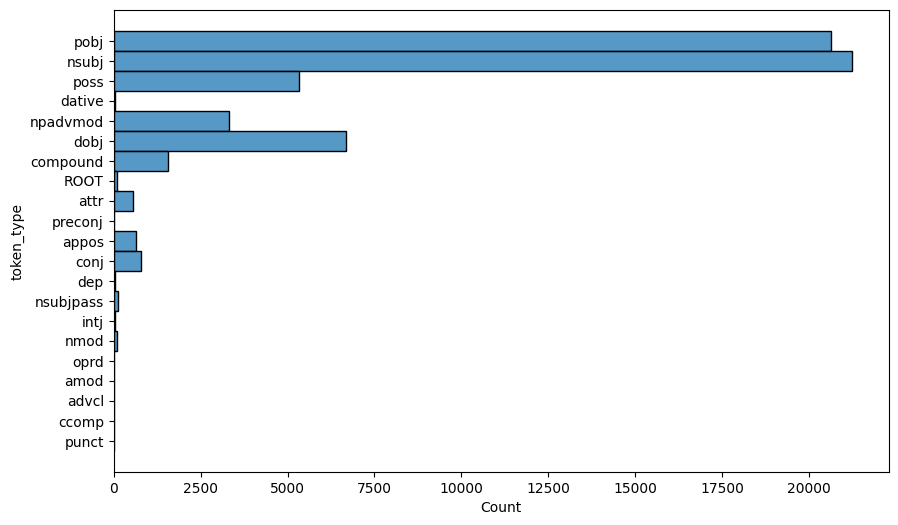

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(y=output["token_type"])
plt.show()

In [36]:
DATA_PATH = "/data/laviniad/congress_errata/classed_congress_df.json"
speech_df = pd.read_json(DATA_PATH)
speech_df['date'] = pd.to_datetime(speech_df['date'].apply(str), format='%Y%m%d')
speech_df['month'] = speech_df['date'].dt.month

In [4]:
speech_df.head()

,bio_id,congress_num,year,date,chamber,speaker,text,month_code,month,gender,...,jesus,faith,pray,old_lexical,old_num_general,old_num_christian,old_binary_lex,lr_label_prop_religious,max_lr_prob,avg_lr_prob
0,L000397,116,2019,2019-01-04,House,Ms. LOFGREN,"Ms. LOFGREN. Madam Speaker, I rise today to ho...",1,1,F,...,False,True,False,0.002558,1,0,True,0.2,0.969980,0.202213
1,W000804,116,2019,2019-01-04,House,Mr. WITTMAN,"Mr. WITTMAN. Madam Speaker, I was not present ...",1,1,M,...,False,False,False,0.000000,0,0,False,0.0,0.000617,0.000617
2,S001201,116,2019,2019-01-04,House,Mr. SUOZZI,"Mr. SUOZZI. Madam Speaker, today is former Con...",1,1,M,...,False,False,False,0.000000,0,0,False,0.1,0.540048,0.063817
3,S001199,116,2019,2019-01-04,House,Mr. SMUCKER,"Mr. SMUCKER. Madam Speaker, I regret I was una...",1,1,M,...,False,False,False,0.000000,0,0,False,0.0,0.036231,0.036231
4,U000031,116,2019,2019-01-04,House,Mr. UPTON,"Mr. UPTON. Madam Speaker, I was unavoidably de...",1,1,M,...,False,False,False,0.000000,0,0,False,0.0,0.074070,0.037090


In [5]:
# label output rows with party and year

output['party'] = output['speech_id'].apply(lambda x: speech_df.loc[x]['party'])
output['year'] = output['speech_id'].apply(lambda x: speech_df.loc[x]['date'].year)

NameError: name 'output' is not defined

In [8]:
def infer_simple_dep_type(row):
    if row['token_type'] == 'nsubj':
        return 'subj'
    elif row['token_type'] == 'nsubjpass':
        return 'subj'
    elif row['token_type'] == 'dobj':
        return 'obj'
    elif row['token_type'] == 'pobj':
        return 'obj'
    else:
        return 'other'
    
output['simple_token_type'] = output.apply(infer_simple_dep_type, axis=1)

In [9]:
num_speeches_per_year = speech_df.groupby('year').size()
output['count'] = 1
output_agg = output.groupby(['year', 'party', 'simple_token_type']).size().reset_index()

In [10]:
# rename output_agg[0] to count
output_agg = output_agg.rename(columns={0: 'count'})

In [11]:
output_agg['count_per_num_speeches'] = output_agg.apply(lambda x: x['count'] / num_speeches_per_year[x['year']], axis=1)

In [12]:
output_agg['party'] = output_agg['party'].apply(lambda x: 'Democrat' if x == 'Democrat' else 'Republican' if x == 'Republican' else 'Other')
# drop 'Other' party rows
output_agg = output_agg[output_agg['party'] != 'Other']

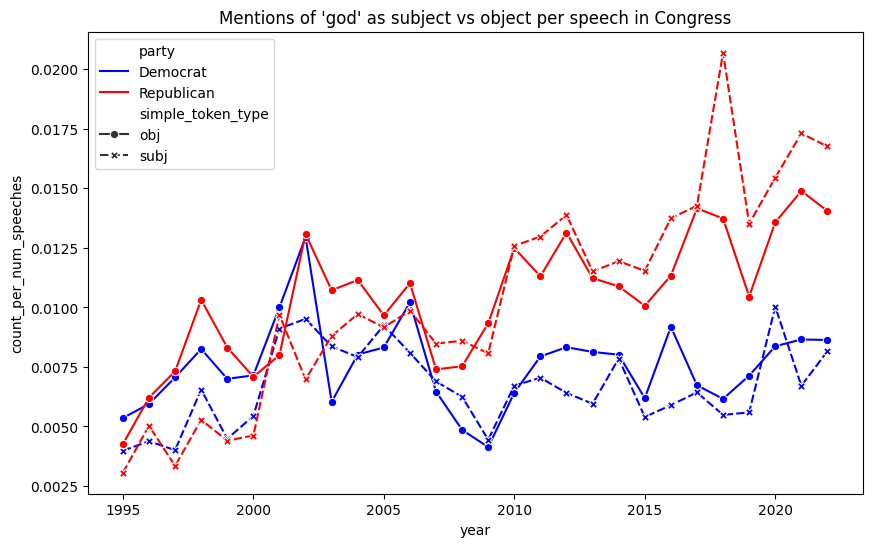

In [13]:
# plot freq of god as subject vs as object over time, wrt year and party
palette = {'Republican': 'red', 'Democrat': 'blue'}
output_agg = output_agg[output_agg['year'] <= 2022]
plot_df = output_agg[output_agg['simple_token_type'] != 'other']

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df, x='year', y='count_per_num_speeches', hue='party', style='simple_token_type', markers=True, palette=palette)
plt.title("Mentions of 'god' as subject vs object per speech in Congress")
plt.show()

In [14]:
output.head()

,speech_id,token,token_idx,token_type,verb,verb_tense,verb_obj_list,verb_subj,adjectives,possessed_by,possessed,run_id,party,year,simple_token_type,count
0,0,God,291,pobj,NaN,NaN,NaN,NaN,[],NaN,NaN,489,Democrat,2019,obj,1
1,12,God,61,pobj,NaN,NaN,NaN,NaN,[],NaN,NaN,489,unknown,2019,obj,1
2,15,God,176,nsubj,bless,other,['troops'],NaN,[],NaN,NaN,489,Republican,2019,subj,1
3,85,God,1505,nsubj,bless,other,['them'],NaN,[],NaN,NaN,489,Republican,2019,subj,1
4,85,God,1516,nsubj,bless,other,['Culver'],NaN,[],NaN,NaN,489,Republican,2019,subj,1


In [15]:
import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp("This is a sentence.")

/home/laviniad/miniconda3/envs/cuda-sermons/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [16]:
for token in doc:
    print(token.lemma_)

this
be
a
sentence
.


In [17]:
def get_lemma(x):
    if isinstance(x, float):
        return x
    return nlp(x)[0].lemma_

output['verb_lemma'] = output['verb'].apply(get_lemma)

In [18]:
# no NaNs in verb column
verbs_only = output[output['verb_lemma'] != 'NaN']

In [19]:
# top 25 most frequent verbs for "God" as subject, per party
top_25_verbs_subj = verbs_only[verbs_only['simple_token_type'] == 'subj'].groupby(['party', 'verb_lemma']).size().reset_index().rename(columns={0: 'count'})
top_25_verbs_obj = verbs_only[verbs_only['simple_token_type'] == 'obj'].groupby(['party', 'verb_lemma']).size().reset_index().rename(columns={0: 'count'})

In [20]:
top_25_verbs_subj[top_25_verbs_subj['party'] == 'Democrat'].sort_values(by='count', ascending=False).groupby('party').head(25)

,party,verb_lemma,count
35,Democrat,bless,3315
129,Democrat,forbid,935
28,Democrat,be,463
138,Democrat,give,462
174,Democrat,know,317
143,Democrat,grant,203
65,Democrat,continue,199
156,Democrat,help,170
345,Democrat,willing,168
347,Democrat,wipe,133


In [21]:
top_25_verbs_subj[top_25_verbs_subj['party'] == 'Republican'].sort_values(by='count', ascending=False).groupby('party').head(25)

,party,verb_lemma,count
413,Republican,bless,6478
444,Republican,continue,695
534,Republican,give,555
404,Republican,be,542
523,Republican,forbid,414
577,Republican,know,228
549,Republican,have,189
553,Republican,help,153
757,Republican,willing,148
594,Republican,make,147


In [22]:
top_25_verbs_obj[top_25_verbs_obj['party'] == 'Democrat'].sort_values(by='count', ascending=False).groupby('party').head(25)

,party,verb_lemma,count
127,Democrat,thank,1621
118,Democrat,serve,136
141,Democrat,worship,96
61,Democrat,help,82
76,Democrat,love,79
13,Democrat,ask,78
92,Democrat,praise,72
89,Democrat,play,36
115,Democrat,see,22
101,Democrat,put,21


In [23]:
top_25_verbs_obj[top_25_verbs_obj['party'] == 'Republican'].sort_values(by='count', ascending=False).groupby('party').head(25)

,party,verb_lemma,count
328,Republican,thank,1357
162,Republican,ask,735
250,Republican,love,179
311,Republican,serve,166
346,Republican,worship,157
230,Republican,help,146
156,Republican,acknowledge,61
270,Republican,play,55
232,Republican,honor,50
273,Republican,praise,47


In [24]:
def load_verb_obj(x):
    if isinstance(x, float):
        return x
    elif x == 'NaN':
        return x
    
    return x[2:-2] # should cut off first two and last two chars (i.e., [' and '])


verbs_only['verb_obj'] = verbs_only['verb_obj_list'].apply(load_verb_obj)

In [25]:
verbs_only.head()

,speech_id,token,token_idx,token_type,verb,verb_tense,verb_obj_list,verb_subj,adjectives,possessed_by,possessed,run_id,party,year,simple_token_type,count,verb_lemma,verb_obj
0,0,God,291,pobj,NaN,NaN,NaN,NaN,[],NaN,NaN,489,Democrat,2019,obj,1,NaN,NaN
1,12,God,61,pobj,NaN,NaN,NaN,NaN,[],NaN,NaN,489,unknown,2019,obj,1,NaN,NaN
2,15,God,176,nsubj,bless,other,['troops'],NaN,[],NaN,NaN,489,Republican,2019,subj,1,bless,troops
3,85,God,1505,nsubj,bless,other,['them'],NaN,[],NaN,NaN,489,Republican,2019,subj,1,bless,them
4,85,God,1516,nsubj,bless,other,['Culver'],NaN,[],NaN,NaN,489,Republican,2019,subj,1,bless,Culver


In [26]:
# common objects of "God" as subject, per party
common_objects_subj = verbs_only[verbs_only['simple_token_type'] == 'subj'].groupby(['party', 'verb_obj']).size().reset_index().rename(columns={0: 'count'})

In [27]:
common_objects_subj[common_objects_subj['party'] == 'Democrat'].sort_values(by='count', ascending=False).head(25)

,party,verb_obj,count
0,Democrat,,2971
919,Democrat,you,814
818,Democrat,them,443
16,Democrat,America,427
860,Democrat,us,325
297,Democrat,States,236
554,Democrat,him,233
791,Democrat,strength,151
809,Democrat,that,149
806,Democrat,tears,132


In [37]:
speech_df.columns

Index(['bio_id', 'congress_num', 'year', 'date', 'chamber', 'speaker', 'text',
       'month_code', 'month', 'gender', 'party', 'state', 'is_in_senate',
       'main_topic', 'is_abortion', 'is_immigration', 'is_christianity',
       'is_science_technology', 'is_health_insurance', 'enclosing_county',
       'perc_adherents', 'religion', 'is_republican', 'church_in_bio',
       'dw_nom_1', 'dw_nom_2', 'lexical', 'num_general', 'num_christian',
       'length', 'binary_lex', 'full_state', 'state_perc_white',
       'state_perc_black', 'god', 'bible', 'jesus', 'faith', 'pray',
       'old_lexical', 'old_num_general', 'old_num_christian', 'old_binary_lex',
       'lr_label_prop_religious', 'max_lr_prob', 'avg_lr_prob'],
      dtype='object')

In [ ]:
# label output df rows with gender
output['gender'] = output['speech_id'].apply(lambda x: speech_df.loc[x]['gender'])

In [57]:
# god as subj vs obj wrt gender in speech_df
from scipy.stats import chi2_contingency

# correlation between being a man and using "god" as subject
table = pd.crosstab(output['simple_token_type'], output['gender'])
stat, p, dof, expected = chi2_contingency(table)
print(stat, p)

33.77717306688647 4.627858390816947e-08


In [58]:
table

gender,F,M
simple_token_type,,
obj,2746,20003
other,1740,10479
subj,2681,18439


In [ ]:
# note: working on getting region -- god as subject verb stats

In [ ]:
output['state'] = output['speech_id'].apply(lambda x: speech_df.loc[x]['state'])

In [66]:
# induce region from state
# drop 'unassigned' state rows
state_to_census_region = {'WA': 'West', 'OR': 'West', 'CA': 'West', 'NV': 'West', 'ID': 'West', 'MT': 'West', 'WY': 'West', 'UT': 'West', 'CO': 'West', 'AZ': 'West', 'NM': 'West', 'AK': 'West', 'HI': 'West',
                          'OK': 'South', 'TX': 'South', 'AR': 'South', 'LA': 'South', 'MS': 'South', 'AL': 'South', 'TN': 'South', 'KY': 'South', 'WV': 'South', 'VA': 'South', 'NC': 'South', 'SC': 'South', 'GA': 'South', 'FL': 'South',
                          'ND': 'Midwest', 'SD': 'Midwest', 'NE': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest', 'MO': 'Midwest', 'WI': 'Midwest', 'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest',
                          'PA': 'Northeast', 'NY': 'Northeast', 'NJ': 'Northeast', 'CT': 'Northeast', 'RI': 'Northeast', 'MA': 'Northeast', 'VT': 'Northeast', 'NH': 'Northeast', 'ME': 'Northeast', 'DE': 'Northeast', 'MD': 'Northeast', 'DC': 'Northeast'}

def get_census_region(x):
    if x in state_to_census_region:
        return state_to_census_region[x]
    else:
        return 'Other'
output['region'] = output['state'].apply(get_census_region)

In [67]:
output_no_other = output[output['region'] != 'Other']
table = pd.crosstab(output_no_other['simple_token_type'], output_no_other['region'])
stat, p, dof, expected = chi2_contingency(table)
print(stat, p)

table_freq = table.div(table.sum(axis=0), axis=1)

247.42400396256775 1.4567151032103577e-50


In [78]:
verbs_only = output[output['verb_lemma'] != 'NaN']

In [81]:
# top 25 most frequent verbs for "God" as subject, per region
top_25_verbs_subj_by_region = verbs_only[verbs_only['simple_token_type'] == 'subj'].groupby(['region', 'verb_lemma']).size().reset_index().rename(columns={0: 'count'})
top_25_verbs_subj_by_gender = verbs_only[verbs_only['simple_token_type'] == 'subj'].groupby(['gender', 'verb_lemma']).size().reset_index().rename(columns={0: 'count'})

In [85]:
top_25_verbs_subj_by_gender[top_25_verbs_subj_by_gender['gender'] == 'M'].sort_values(by='count', ascending=False).head(25)

,gender,verb_lemma,count
225,M,bless,8483
361,M,forbid,1186
215,M,be,903
373,M,give,839
266,M,continue,799
426,M,know,501
380,M,grant,309
656,M,willing,291
396,M,help,274
392,M,have,272


In [86]:
top_25_verbs_subj_by_gender[top_25_verbs_subj_by_gender['gender'] == 'F'].sort_values(by='count', ascending=False).head(25)

,gender,verb_lemma,count
13,F,bless,1332
63,F,give,180
57,F,forbid,166
10,F,be,105
25,F,continue,96
82,F,know,64
72,F,help,49
70,F,have,46
94,F,make,39
66,F,grant,36


In [87]:
# calculate KL divergence between top 25 verbs for "God" as subject, per region
from scipy.stats import entropy

def kl_divergence(p, q):
    return entropy(p, q)

def get_top_25_verbs(df):
    return df.sort_values(by='count', ascending=False).head(25)

top_25_verbs_subj_by_region = top_25_verbs_subj_by_region.groupby('region').apply(get_top_25_verbs)
top_25_verbs_subj_by_region = top_25_verbs_subj_by_region.pivot(index='verb_lemma', columns='region', values='count').fillna(0)

for region in top_25_verbs_subj_by_region.columns:
    top_25_verbs_subj_by_region[region] = top_25_verbs_subj_by_region[region] / top_25_verbs_subj_by_region[region].sum()

for region_pair in [(region1, region2) for region1 in top_25_verbs_subj_by_region.columns for region2 in top_25_verbs_subj_by_region.columns]:
    region1, region2 = region_pair
    kl = kl_divergence(top_25_verbs_subj_by_region[region1], top_25_verbs_subj_by_region[region2])
    print(f"KL divergence between {region1} and {region2}: {kl}")


KL divergence between Midwest and Midwest: 0.0
KL divergence between Midwest and Northeast: inf
KL divergence between Midwest and Other: inf
KL divergence between Midwest and South: inf
KL divergence between Midwest and West: inf
KL divergence between Northeast and Midwest: inf
KL divergence between Northeast and Northeast: 0.0
KL divergence between Northeast and Other: inf
KL divergence between Northeast and South: inf
KL divergence between Northeast and West: inf
KL divergence between Other and Midwest: inf
KL divergence between Other and Northeast: inf
KL divergence between Other and Other: 0.0
KL divergence between Other and South: inf
KL divergence between Other and West: inf
KL divergence between South and Midwest: inf
KL divergence between South and Northeast: inf
KL divergence between South and Other: inf
KL divergence between South and South: 0.0
KL divergence between South and West: inf
KL divergence between West and Midwest: inf
KL divergence between West and Northeast: inf


/tmp/ipykernel_3625585/1177315957.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_25_verbs_subj_by_region = top_25_verbs_subj_by_region.groupby('region').apply(get_top_25_verbs)


In [75]:
# rank regions by frequency of "god" as subject
table_freq.loc['subj'].sort_values(ascending=False)

region
South        0.385793
Midwest      0.385593
Northeast    0.365102
West         0.342922
Name: subj, dtype: float64

In [76]:
# find each region's top 5 most frequent verbs for "god" as subject
top_5_verbs_subj = [verbs_only['simple_token_type'] == 'subj'].groupby(['region', 'verb_lemma']).size().reset_index().rename(columns={0: 'count'})
print(top_5_verbs_subj[top_5_verbs_subj['region'] == 'Northeast'].sort_values(by='count', ascending=False).head(5))
print(top_5_verbs_subj[top_5_verbs_subj['region'] == 'Midwest'].sort_values(by='count', ascending=False).head(5))
print(top_5_verbs_subj[top_5_verbs_subj['region'] == 'South'].sort_values(by='count', ascending=False).head(5))
print(top_5_verbs_subj[top_5_verbs_subj['region'] == 'West'].sort_values(by='count', ascending=False).head(5))

KeyError: 'region'

In [ ]:
# god as subj vs obj wrt gender in speech_df
from scipy.stats import chi2_contingency

# correlation between being a man and using "god" as subject
table = pd.crosstab(output['simple_token_type'], output['gender'])
stat, p, dof, expected = chi2_contingency(table)
print(stat, p)

In [43]:
!pip install wordtree

In [39]:
import wordtree
import re

def prep_string(x):
    x = x.lower()
    # remove punctuation using regex
    x = re.sub(r'[^\w\s]', '', x)
    
    return x

documents = speech_df['text'].apply(prep_string).tolist()
print("Loaded documents list")
g = wordtree.search_and_draw(corpus = documents, keyword = "bible")
print("Created wordtree")

Loaded documents list


  0%|          | 0/1328805 [00:00<?, ?it/s]

Created wordtree


In [97]:
g.render(directory="/home/laviniad/projects/religion_in_congress/notebooks/summer_notebooks/bible")

'/home/laviniad/projects/religion_in_congress/notebooks/summer_notebooks/bible.png.png'